In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime as dt
%matplotlib inline  

In [2]:
file ="20200621_merged_contract_data.xlsx"
df = pd.read_excel(file)

In [4]:
df = df[df["FMS"]==False]
df.shape

(59225, 14)

In [6]:
pivoted_df = pd.pivot_table(data=df, columns="JFY", index="contractor", values="contract_amount",
                            aggfunc=np.mean).reset_index()

In [8]:
null_count = []
for i in range(pivoted_df.shape[0]):
    row = pivoted_df.iloc[i,]
    nulls = row.isnull().sum()
    null_count.append(nulls)

In [9]:
null_count
not_null_contractors_index = []
for index, value in enumerate(null_count):
    if value == 0:
        not_null_contractors_index.append(index)
    else:
        pass

In [11]:
not_null_df = pivoted_df.iloc[not_null_contractors_index,:]

In [12]:
not_null_df["total"] = not_null_df.sum(axis=1)

/Users/rairaokuno/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
pd.pivot_table(data=not_null_df, index="contractor", aggfunc=np.average)

TypeError: '<' not supported between instances of 'str' and 'int'

In [14]:
cols = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [15]:
dataframe = not_null_df[cols]
dataframe.head()

JFY,2011,2012,2013,2014,2015,2016,2017,2018,2019
8,6.156562e+08,4.323895e+08,155147700.0,1.038022e+09,1.583112e+09,2.058534e+09,6123600.00,1.274868e+09,2.575353e+09
21,7.105035e+07,9.872415e+06,26195400.0,2.412725e+07,6.265890e+06,2.788610e+07,72017296.50,2.429741e+07,5.247110e+06
25,1.269274e+08,5.880339e+08,223913016.0,1.020288e+08,1.005796e+08,3.175773e+07,55336834.75,1.652734e+08,1.252434e+08
28,1.176000e+07,7.218750e+07,84277800.0,1.253070e+08,8.202600e+07,4.101300e+07,41015970.00,4.406832e+07,8.657000e+07
31,9.439272e+06,6.150207e+06,28231332.0,6.619396e+07,9.077008e+06,1.969920e+06,20217168.00,3.853613e+07,3.260488e+07


In [16]:
#平均0, 標準偏差1で標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Apply StandardScaler with transposed dataframe
df2_std = scaler.fit_transform(dataframe.T) 
# Return the dataframe to normal shape with transposion
df_std = pd.DataFrame(df2_std).T

In [17]:
df_std.columns = cols

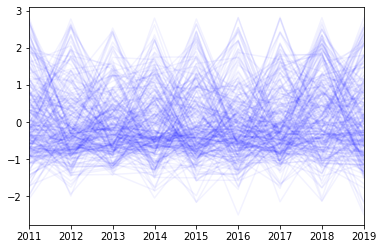

In [18]:
df_std.T.plot(color='blue', alpha=0.05, legend=False)

In [19]:
from sklearn.cluster import KMeans

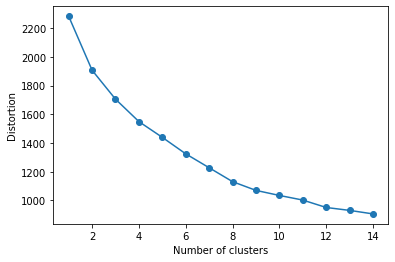

In [20]:
data = df_std
distortions = []

for i  in range(1,15):                # 1~15クラスタまで計算 
    km = KMeans(n_clusters=i, random_state=1234)
    km.fit(data)                       # クラスタリングの計算を実行
    distortions.append(km.inertia_)   # km.fitするとkm.inertia_が得られる

plt.plot(range(1,15),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.savefig('elbow_cont_amount.png')
plt.show()

In [21]:
n_clusters = 3
# モデルを初期化
km =KMeans(n_clusters=n_clusters, random_state=1234)

# 学習は教師あり学習と同じように　model.fit(data)で実行します
km.fit(data)

# ラベルを付与する場合も教師あり学習同様に model.predict(data)で実行します
cluster_labels = km.predict(data)

In [22]:
df_std["cluster_labels"] = cluster_labels
df_std["contractor"] = list(not_null_df["contractor"])
df_std["total_cont_amount"] = list(not_null_df["total"])
df_std.head()

,2011,2012,2013,2014,2015,2016,2017,2018,2019,cluster_labels,contractor,total_cont_amount
0,-0.565226,-0.787288,-1.123218,-0.053450,0.607029,1.183093,-1.303789,0.233534,1.809316,1,GEアビエーション・ディストリビューション・ジャパン株式会社,9.739206e+09
1,1.735823,-0.829981,-0.145395,-0.232133,-0.981239,-0.074487,1.776377,-0.224997,-1.023967,2,KDDI株式会社,2.669592e+08
2,-0.265802,2.662068,0.350024,-0.423900,-0.433102,-0.870097,-0.720378,-0.022318,-0.276495,2,NECネッツエスアイ株式会社,1.519094e+09
3,-1.673003,0.213161,0.590544,1.871216,0.520257,-0.759909,-0.759817,-0.664542,0.662092,0,NECファシリティーズ株式会社,5.882256e+08
4,-0.735731,-0.906591,0.240472,2.212542,-0.754550,-1.123747,-0.175845,0.775782,0.467668,1,NTTファイナンス株式会社,2.124199e+08


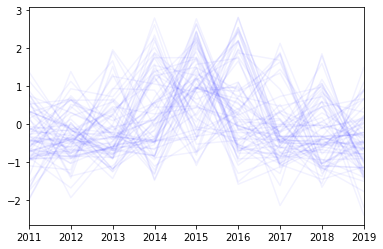

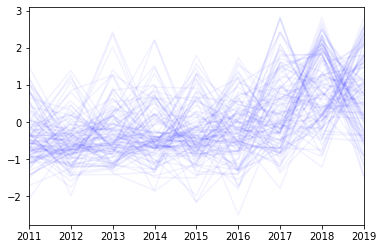

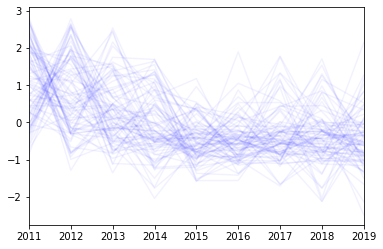

In [23]:
# Surge in a certain year makes it hard to catch the gradual sales increase
columns = cols
for i in range(n_clusters):
    df_std[df_std["cluster_labels"] == i][columns].T.plot(color='blue', alpha=0.05, legend=False)
    plt.savefig(str(i)+'_small_elbow.png')

In [24]:
pd.pivot_table(data=df_std, 
               index="cluster_labels",
               values="contractor", 
               aggfunc=["count"]).reset_index()

,cluster_labels,count
,,contractor
0,0,70
1,1,105
2,2,81


In [31]:
df_std[df_std["cluster_labels"] == 1].head()

,2011,2012,2013,2014,2015,2016,2017,2018,2019,cluster_labels,contractor,total_cont_amount
0,-0.565226,-0.787288,-1.123218,-0.053450,0.607029,1.183093,-1.303789,0.233534,1.809316,1,GEアビエーション・ディストリビューション・ジャパン株式会社,9.739206e+09
4,-0.735731,-0.906591,0.240472,2.212542,-0.754550,-1.123747,-0.175845,0.775782,0.467668,1,NTTファイナンス株式会社,2.124199e+08
8,0.838737,-1.196971,-1.192719,0.209020,-0.228226,1.200561,-1.027190,1.666240,-0.269452,1,アキレス株式会社,6.319489e+07
10,-0.906387,-0.971371,-0.946737,-0.679657,-0.136259,0.725068,1.144518,1.993233,-0.222407,1,アンリツ株式会社,1.419861e+08
11,-0.900443,-1.183114,-0.828086,0.664153,-0.451019,-0.556720,0.477240,0.659992,2.117998,1,イズミ産業株式会社,5.833280e+07


In [27]:
file = '20200627_num_conts_cluster.xlsx'
df_num_clust = pd.read_excel(file)

In [28]:
df_merged = pd.merge(df_std, df_num_clust[["contractor", "cluster_labels_num_cont"]],
                     left_on =["contractor"], 
                     right_on =["contractor"],
                     how = "left")

In [36]:
from datetime import datetime
tmpTime = datetime.now().strftime("%Y%m%d")
filename= tmpTime+"_cont_clusrtered"+'.xlsx'
# df_merged.to_csv(filename, index=False)
df_merged.to_excel(filename, index=False)

In [32]:
# 上昇軍団
key1 = df_merged["cluster_labels_num_cont"]== 2
key2 = df_merged["cluster_labels"]== 1
print(df_merged[key1 & key2].shape)
df_merged[key1 & key2]

(27, 13)


,2011,2012,2013,2014,2015,2016,2017,2018,2019,cluster_labels,contractor,total_cont_amount,cluster_labels_num_cont
10,-0.906387,-0.971371,-0.946737,-0.679657,-0.136259,0.725068,1.144518,1.993233,-0.222407,1,アンリツ株式会社,1.419861e+08,2
11,-0.900443,-1.183114,-0.828086,0.664153,-0.451019,-0.556720,0.477240,0.659992,2.117998,1,イズミ産業株式会社,5.833280e+07,2
19,-0.730957,-0.767998,-0.689335,-0.759976,-0.490758,0.105978,-0.176400,1.317777,2.191668,1,コーンズテクノロジー株式会社,5.367186e+08,2
24,-0.993999,-0.615380,-0.330916,-0.463582,0.288115,-0.781977,0.315410,0.030081,2.552249,1,ジャパンカスタム株式会社,4.329633e+07,2
28,-0.878939,-0.464629,-0.065622,-0.276507,-0.338215,0.250512,-0.268279,2.693783,-0.652104,1,タレスジャパン株式会社,3.279447e+09,2
29,0.330806,-0.726072,0.803937,-1.383302,0.693266,-0.524712,-0.807880,2.050463,-0.436506,1,ダイキン工業株式会社,3.686174e+09,2
47,1.513264,-0.595963,0.247836,-1.857424,-1.062346,0.057322,0.989181,-0.137029,0.845159,1,三甲テキスタイル株式会社,5.231146e+08,2
49,-0.796200,-0.061041,-0.252048,-0.711473,-0.596687,-0.799339,1.823665,1.814928,-0.421807,1,三菱スペース・ソフトウエア株式会社,1.795183e+09,2
69,-0.349503,-0.369411,-0.313883,-0.383194,-0.342317,-0.396233,2.827539,-0.322386,-0.350613,1,兼松株式会社,1.363078e+09,2
87,0.059564,-0.373204,0.153762,-1.036045,-1.221074,-0.464691,1.584353,1.810878,-0.513543,1,山甚物産株式会社,6.305858e+07,2


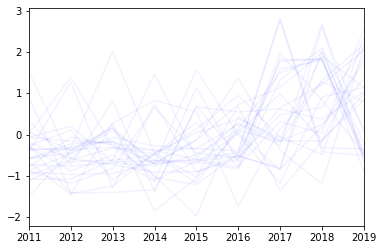

In [33]:
df_merged[key1 & key2][cols].T.plot(color='blue', alpha=0.05, legend=False)

In [34]:
# 下降軍団
key3 = df_merged["cluster_labels_num_cont"]== 0
key4 = df_merged["cluster_labels"]== 2
print(df_merged[key3 & key4].shape)
df_merged[key3 & key4]

(37, 13)


,2011,2012,2013,2014,2015,2016,2017,2018,2019,cluster_labels,contractor,total_cont_amount,cluster_labels_num_cont
1,1.735823,-0.829981,-0.145395,-0.232133,-0.981239,-0.074487,1.776377,-0.224997,-1.023967,2,KDDI株式会社,2.669592e+08,0
30,1.874678,1.191339,-1.355226,0.505436,-0.466727,0.133732,-0.055637,-0.733066,-1.094527,2,デンヨー株式会社,1.539030e+08,0
32,0.160987,1.963980,-1.105384,-1.148097,-0.085536,1.049702,0.574052,-0.973653,-0.436050,2,トヨタエルアンドエフ東京株式会社,1.356083e+08,0
35,1.500422,-0.296305,0.374734,-1.769730,-0.812654,0.289185,1.323157,0.290768,-0.899578,2,ホシザキ東京株式会社,1.684694e+07,0
36,1.035995,0.555073,1.619665,1.055305,-1.178479,-1.019542,-0.577361,-0.678342,-0.812313,2,ホリカフーズ株式会社,8.622226e+07,0
44,0.673555,2.627127,-0.471009,-0.285999,-0.427159,-0.359478,-0.578025,-0.584775,-0.594236,2,三信製織株式会社,2.501405e+08,0
48,1.307967,1.693789,-0.097643,0.339118,-1.088158,-0.846401,-0.995416,0.666588,-0.979844,2,三菱ふそうトラック・バス株式会社,9.250876e+08,0
55,0.732664,0.497645,1.410991,-1.281803,0.499899,-0.117192,-1.664210,-0.918022,0.840029,2,中国化薬株式会社,2.413251e+08,0
68,0.565553,1.702469,-0.161261,-2.040086,-0.588900,-0.563690,0.420896,0.847760,-0.182741,2,住鉱潤滑剤株式会社,3.491236e+07,0
103,0.333434,2.180982,0.211977,-0.510667,-0.728265,-0.372906,-1.042604,0.980731,-1.052681,2,日本トレクス株式会社,3.846373e+08,0


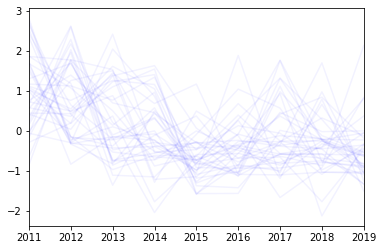

In [35]:
df_merged[key3 & key4][cols].T.plot(color='blue', alpha=0.05, legend=False)